In [1]:
import numpy as np

import seaborn as sns
from matplotlib import pyplot as plt

from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

import torch
from torch import nn
from torch.nn import functional as F

from torch.utils.data import TensorDataset, DataLoader

sns.set(style="darkgrid", font_scale=1.4)

# Часть 2. Датасет MNIST
Датасет MNIST содержит рукописные цифры. Загрузим датасет и создадим DataLoader-ы. Пример можно найти в семинаре по полносвязным нейронным сетям.

In [2]:
import os
from torchvision.datasets import MNIST
from torchvision import transforms as tfs


data_tfs = tfs.Compose([
    tfs.ToTensor(),
    tfs.Normalize((0.5), (0.5))
])

# install for train and test
root = './'
train_dataset = MNIST(root, train=True,  transform=data_tfs, download=True)
val_dataset  = MNIST(root, train=False, transform=data_tfs, download=True)

train_dataloader =  DataLoader(train_dataset, batch_size=128)
valid_dataloader =  DataLoader(val_dataset, batch_size=128)

Failed to download (trying next):
<urlopen error [WinError 10061] Подключение не установлено, т.к. конечный компьютер отверг запрос на подключение>



100%|██████████| 9.91M/9.91M [00:04<00:00, 2.28MB/s]


Extracting ./MNIST\raw\train-images-idx3-ubyte.gz to ./MNIST\raw

Failed to download (trying next):
<urlopen error [WinError 10060] Попытка установить соединение была безуспешной, т.к. от другого компьютера за требуемое время не получен нужный отклик, или было разорвано уже установленное соединение из-за неверного отклика уже подключенного компьютера>



100%|██████████| 28.9k/28.9k [00:00<00:00, 120kB/s]


Extracting ./MNIST\raw\train-labels-idx1-ubyte.gz to ./MNIST\raw

Failed to download (trying next):
<urlopen error [WinError 10061] Подключение не установлено, т.к. конечный компьютер отверг запрос на подключение>



100%|██████████| 1.65M/1.65M [00:01<00:00, 898kB/s]


Extracting ./MNIST\raw\t10k-images-idx3-ubyte.gz to ./MNIST\raw

Failed to download (trying next):
<urlopen error [WinError 10060] Попытка установить соединение была безуспешной, т.к. от другого компьютера за требуемое время не получен нужный отклик, или было разорвано уже установленное соединение из-за неверного отклика уже подключенного компьютера>



100%|██████████| 4.54k/4.54k [00:00<?, ?B/s]

Extracting ./MNIST\raw\t10k-labels-idx1-ubyte.gz to ./MNIST\raw



## Часть 2.2 Сверточные нейронные сети

### Ядра
Сначала немного поработам с самим понятием ядра свёртки.

In [ ]:
!wget https://img.the-village.kz/the-village.com.kz/post-cover/5x5-I6oiwjmq79dMCZMEbA-default.jpg -O sample_photo.jpg

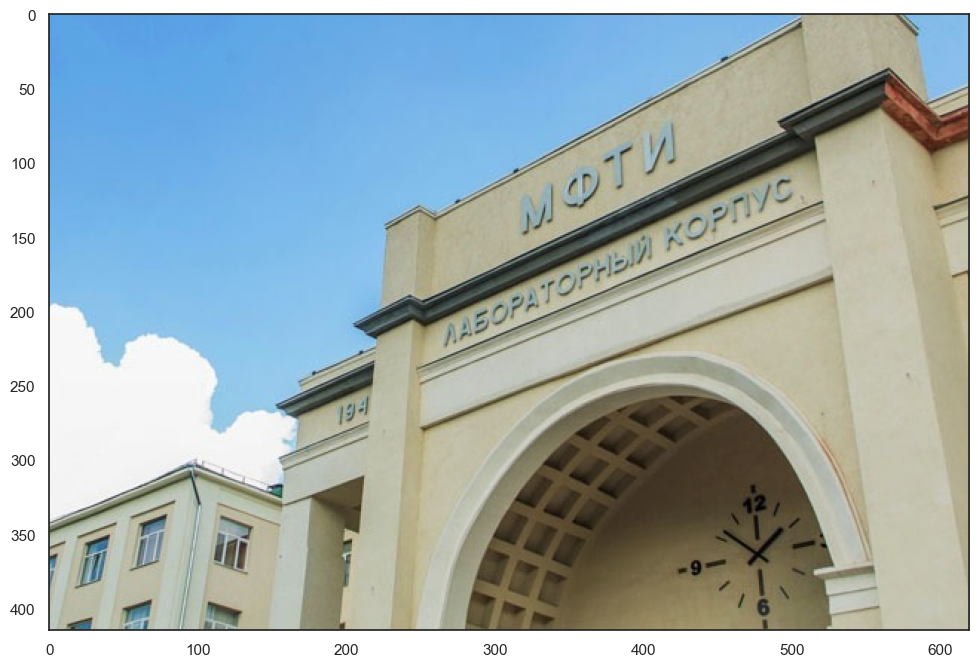

In [3]:
import cv2
sns.set(style="white")
img = cv2.imread("sample_photo.jpg")
RGB_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(12, 8))
plt.imshow(RGB_img)
plt.show()

Попробуйте посмотреть как различные свертки влияют на фото. Например, попробуйте
A)
```
[0, 0, 0],
[0, 1, 0],
[0, 0, 0]
```
Б)
```
[0, 1, 0],
[0, -2, 0],
[0, 1, 0]
```
В)
```
[0, 0, 0],
[1, -2, 1],
[0, 0, 0]
```
Г)
```
[0, 1, 0],
[1, -4, 1],
[0, 1, 0]
```
Д)
```
[0, -1, 0],
[-1, 5, -1],
[0, -1, 0]
```
Е)
```
[0.0625, 0.125, 0.0625],
[0.125, 0.25, 0.125],
[0.0625, 0.125, 0.0625]
```

Не стесняйтесь пробовать свои варианты!

In [20]:
img_t = torch.from_numpy(RGB_img).type(torch.float32).unsqueeze(0)
kernel = torch.tensor([
[0, -1, 0],
[-1, 5, -1],
[0, -1, 0]
]).reshape(1, 1, 3, 3).type(torch.float32)

kernel = kernel.repeat(3, 3, 1, 1)
img_t = img_t.permute(0, 3, 1, 2)  # [BS, H, W, C] -> [BS, C, H, W]
img_t = nn.ReflectionPad2d(1)(img_t)  # Pad Image for same output size

result = F.conv2d(img_t, kernel)[0]  #

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


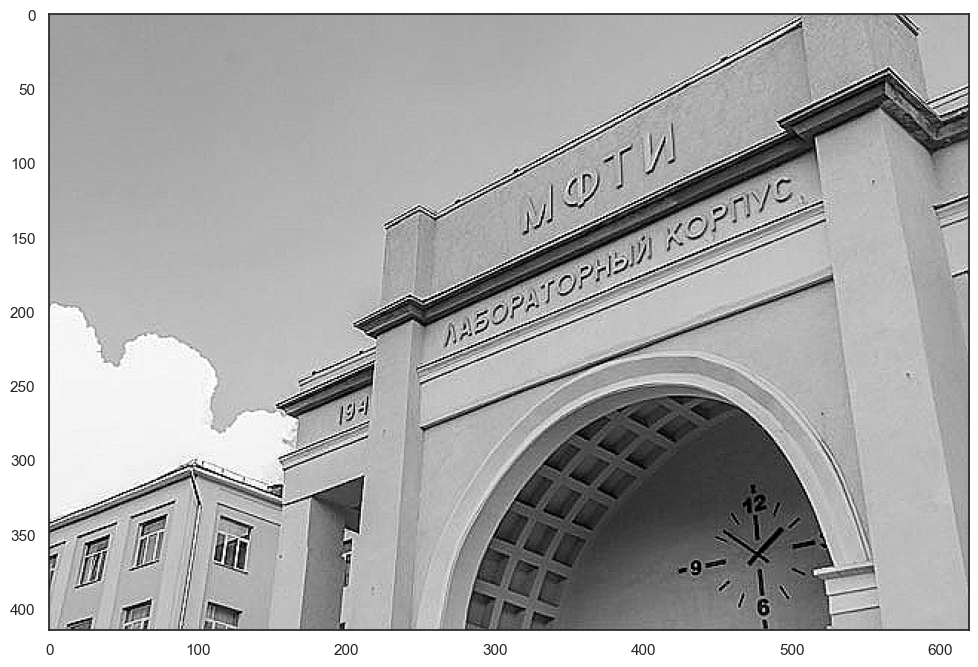

In [21]:
plt.figure(figsize=(12, 8))
result_np = result.permute(1, 2, 0).numpy() / 256 / 3

plt.imshow(result_np)
plt.show()

**Вопрос 5.** Как можно описать действия ядер, приведенных выше? Сопоставьте для каждой буквы число.

1) Размытие

2) Увеличение резкости

3) Тождественное преобразование

4) Выделение вертикальных границ

5) Выделение горизонтальных границ

6) Выделение границ

**Ответ:** А -3 , Б - 4, В - 5, Г - 6, Д - 2, Е - 1

### Задание. Реализуйте LeNet

Если мы сделаем параметры сверток обучаемыми, то можем добиться хороших результатов для задач компьютерного зрения. Реализуйте архитектуру LeNet, предложенную еще в 1998 году!
На этот раз используйте модульную структуру (без помощи класса Sequential).

Наша нейронная сеть будет состоять из
* Свёртки 3x3 (1 карта на входе, 6 на выходе) с активацией ReLU;
* MaxPooling-а 2x2;
* Свёртки 3x3 (6 карт на входе, 16 на выходе) с активацией ReLU;
* MaxPooling-а 2x2;
* Уплощения (nn.Flatten);
* Полносвязного слоя со 120 нейронами и активацией ReLU;
* Полносвязного слоя с 84 нейронами и активацией ReLU;
* Выходного слоя из 10 нейронов.




In [27]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        # 1 input image channel, 6 output channels, 3x3 square conv kernel
        self.conv1 = nn.Conv2d(1, 6, 3)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 3)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(16*5*5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        x = F.relu(self.conv2(x))
        x = self.pool2(x)
        flatten = nn.Flatten(start_dim=1)
        x = flatten(x)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [28]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [35]:
model = LeNet().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

loaders = {"train": train_dataloader, "valid": valid_dataloader}

### Задание. Обучите CNN
Используйте код обучения, который вы написали для полносвязной нейронной сети.

In [32]:
class LeNet(nn.Module):
    def __init__(self, activation=nn.ReLU()):
        super(LeNet, self).__init__()
        self.activation = activation  # The activation we'll use throughout
        
        self.conv1 = nn.Conv2d(1, 6, 3)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 3)
        self.pool2 = nn.MaxPool2d(2, 2)
        
        self.flatten = nn.Flatten(start_dim=1)
        self.fc1 = nn.Linear(16*5*5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.activation(self.conv1(x))
        x = self.pool1(x)
        x = self.activation(self.conv2(x))
        x = self.pool2(x)
        x = self.flatten(x)
        x = self.activation(self.fc1(x))
        x = self.activation(self.fc2(x))
        x = self.fc3(x)
        return x


In [37]:
def train_model(activation, loaders, device, 
                num_epochs=10, 
                learning_rate=1e-3):

    # 1) Create model, loss, optimizer
    model = LeNet(activation=activation).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    # 2) Dictionaries (or lists) for logging accuracy
    accuracy = {"train": [], "valid": []}
    
    # 3) Training loop
    for epoch in range(num_epochs):
        for phase in ["train", "valid"]:
            if phase == "train":
                model.train()
            else:
                model.eval()
                
            running_correct = 0
            running_total = 0

            for inputs, labels in loaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Zero grads only if in training
                if phase == "train":
                    optimizer.zero_grad()

                # Forward
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    _, preds = torch.max(outputs, 1)

                    # Backprop only in training
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # Accumulate for accuracy
                running_correct += (preds == labels).sum().item()
                running_total += labels.size(0)

            # Accuracy for the epoch
            epoch_accuracy = running_correct / running_total
            accuracy[phase].append(epoch_accuracy)

        # Print epoch results
        print(f"Epoch [{epoch+1}/{num_epochs}] "
              f"- Train Acc: {accuracy['train'][-1]:.4f}, "
              f"Valid Acc: {accuracy['valid'][-1]:.4f}")

    return accuracy


In [30]:
max_epochs = 10
accuracy = {"train": [], "valid": []}

for epoch in range(max_epochs):
    for phase in ['train', 'valid']:
        if phase == 'train':
            model.train()
        else:
            model.eval()
        
        running_correct = 0
        running_total = 0
        
        for inputs, labels in loaders[phase]:
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            
            with torch.set_grad_enabled(phase == 'train'):
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                _, preds = torch.max(outputs, 1)
                
                if phase == 'train':
                    loss.backward()
                    optimizer.step()
            
            running_correct += (preds == labels).sum().item()
            running_total += labels.size(0)
        
        epoch_accuracy = running_correct / running_total
        accuracy[phase].append(epoch_accuracy)
        print(f'Epoch {epoch+1}, {phase} Accuracy: {epoch_accuracy:.4f}')

Epoch 1, train Accuracy: 0.8814
Epoch 1, valid Accuracy: 0.9608
Epoch 2, train Accuracy: 0.9680
Epoch 2, valid Accuracy: 0.9723
Epoch 3, train Accuracy: 0.9777
Epoch 3, valid Accuracy: 0.9772
Epoch 4, train Accuracy: 0.9820
Epoch 4, valid Accuracy: 0.9811
Epoch 5, train Accuracy: 0.9849
Epoch 5, valid Accuracy: 0.9831
Epoch 6, train Accuracy: 0.9878
Epoch 6, valid Accuracy: 0.9844
Epoch 7, train Accuracy: 0.9900
Epoch 7, valid Accuracy: 0.9857
Epoch 8, train Accuracy: 0.9920
Epoch 8, valid Accuracy: 0.9865
Epoch 9, train Accuracy: 0.9932
Epoch 9, valid Accuracy: 0.9858
Epoch 10, train Accuracy: 0.9941
Epoch 10, valid Accuracy: 0.9868


In [38]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

loaders = {"train": train_dataloader ,"valid": valid_dataloader}
relu_accuracy = train_model( activation=nn.ReLU(), loaders=loaders, device=device, num_epochs=10, learning_rate=1e-3)
leaky_relu_accuracy = train_model(activation=nn.LeakyReLU(negative_slope=0.01), loaders=loaders, device=device, num_epochs=10, learning_rate=1e-3)
elu_accuracy = train_model(activation=nn.ELU(alpha=1.0), loaders=loaders, device=device, num_epochs=10, learning_rate=1e-3)


Epoch [1/10] - Train Acc: 0.8742, Valid Acc: 0.9633
Epoch [2/10] - Train Acc: 0.9668, Valid Acc: 0.9733
Epoch [3/10] - Train Acc: 0.9782, Valid Acc: 0.9775
Epoch [4/10] - Train Acc: 0.9836, Valid Acc: 0.9824
Epoch [5/10] - Train Acc: 0.9871, Valid Acc: 0.9833
Epoch [6/10] - Train Acc: 0.9891, Valid Acc: 0.9836
Epoch [7/10] - Train Acc: 0.9912, Valid Acc: 0.9837
Epoch [8/10] - Train Acc: 0.9926, Valid Acc: 0.9840
Epoch [9/10] - Train Acc: 0.9935, Valid Acc: 0.9862
Epoch [10/10] - Train Acc: 0.9944, Valid Acc: 0.9868
Epoch [1/10] - Train Acc: 0.8797, Valid Acc: 0.9700
Epoch [2/10] - Train Acc: 0.9701, Valid Acc: 0.9791
Epoch [3/10] - Train Acc: 0.9811, Valid Acc: 0.9815
Epoch [4/10] - Train Acc: 0.9854, Valid Acc: 0.9829
Epoch [5/10] - Train Acc: 0.9878, Valid Acc: 0.9846
Epoch [6/10] - Train Acc: 0.9897, Valid Acc: 0.9844
Epoch [7/10] - Train Acc: 0.9919, Valid Acc: 0.9837
Epoch [8/10] - Train Acc: 0.9928, Valid Acc: 0.9853
Epoch [9/10] - Train Acc: 0.9943, Valid Acc: 0.9854
Epoch [10/1

In [31]:
lenet_accuracy = accuracy["valid"]

In [39]:
relu_valid_acc = relu_accuracy["valid"]
leaky_relu_valid_acc = leaky_relu_accuracy["valid"]
elu_valid_acc = elu_accuracy["valid"]

In [43]:
print(lenet_accuracy[-1], relu_valid_acc[-1], leaky_relu_valid_acc[-1], elu_valid_acc[1])

0.9868 0.9868 0.9875 0.9786


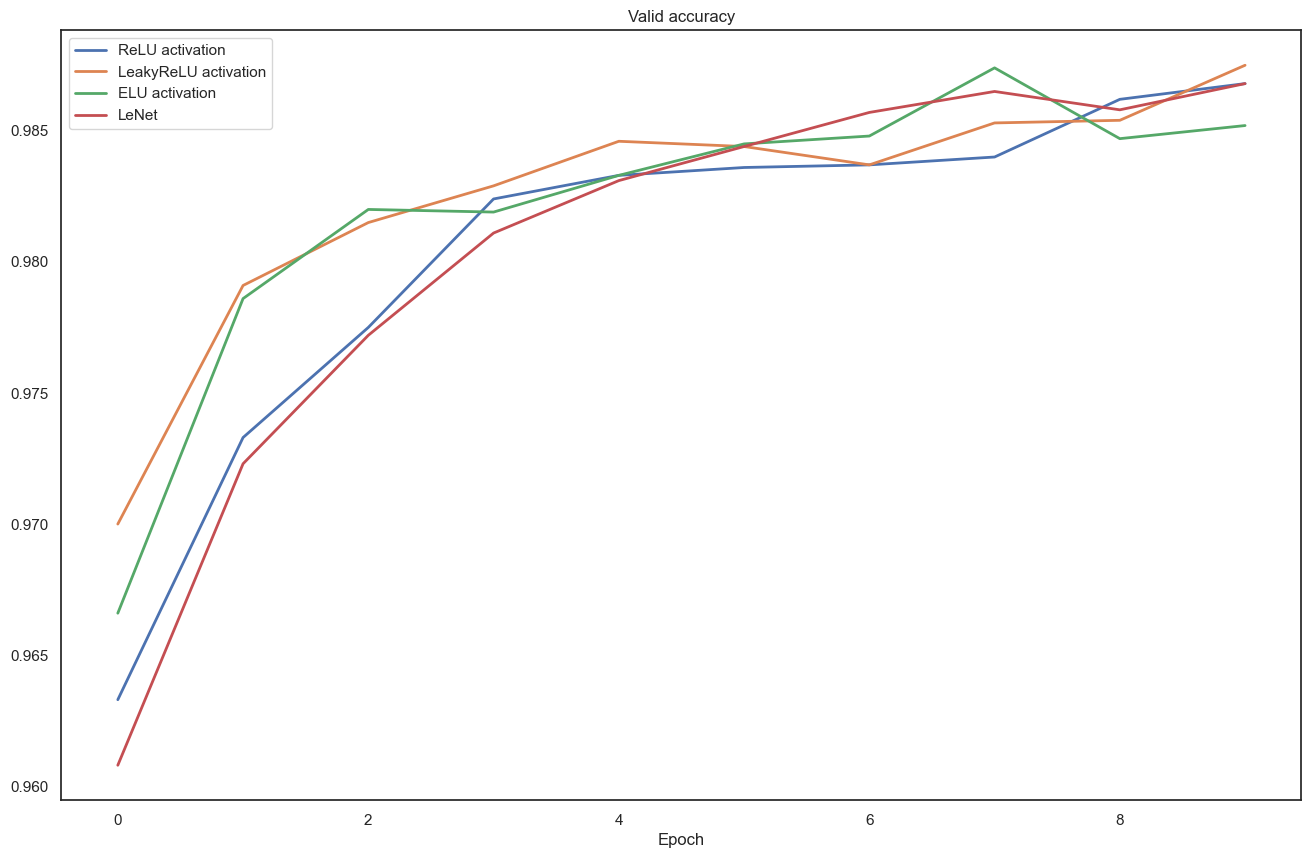

In [42]:
plt.figure(figsize=(16, 10))
plt.title("Valid accuracy")
plt.plot(range(max_epochs), relu_valid_acc, label="ReLU activation", linewidth=2)
plt.plot(range(max_epochs), leaky_relu_valid_acc, label="LeakyReLU activation", linewidth=2)
plt.plot(range(max_epochs), elu_valid_acc, label="ELU activation", linewidth=2)
plt.plot(range(max_epochs), lenet_accuracy, label="LeNet", linewidth=2)
plt.legend()
plt.xlabel("Epoch")
plt.show()

**Вопрос 6**
Какое `accuracy` получается после обучения с точностью до двух знаков после запятой?

**Ответ:** 0.98